**Github**:

**Step 1:Create the dataset featuring 3 categories of 120 images each**

In [1]:
import urllib.request

# Define the download URL and target path
dataset_url = "https://github.com/sarahsha2023/Deep_Learning_DATA255/raw/Hw3_Custom_CNNS/animals_3.zip"
target_path = "animals_3.zip"

# Download the dataset
urllib.request.urlretrieve(dataset_url, target_path)

print("Dataset downloaded successfully!")

Dataset downloaded successfully!


In [2]:
import zipfile
import os
# Extract the downloaded file


with zipfile.ZipFile(target_path) as zip_file:
    file_names = zip_file.namelist()
    filtered_file_names = list(filter(lambda f: '__MACOSX' not in f, file_names))
    zip_file.extractall(members=filtered_file_names)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [3]:
import os
# Define the main data directory
data_dir = "animals"
print(data_dir)

animals


In [4]:
# Count images and print size
total_images = 0
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust for your image formats
            total_images += 1
            image_path = os.path.join(root, file)

print("Total images downloaded:", total_images)

Total images downloaded: 360


In [5]:
import pathlib
from PIL import Image

# define the function to get an sample of image
# ‘category’ represents r type of animal we want to see.
# ‘index’ represent the index of the specific animal within that category.
def image_sample(category, index=75):
    category_path = pathlib.Path(data_dir) / category
    category_imgs = list(category_path.glob('*.jpeg'))+list(category_path.glob('*.jpg'))+list(category_path.glob('*.png'))

    return Image.open(str(category_imgs[index]))

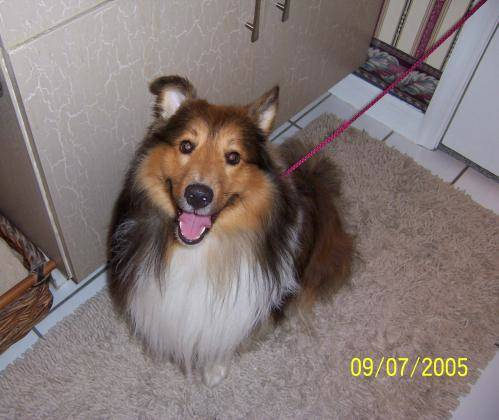

In [6]:
# show the sample of the dog
image_sample('dogs')

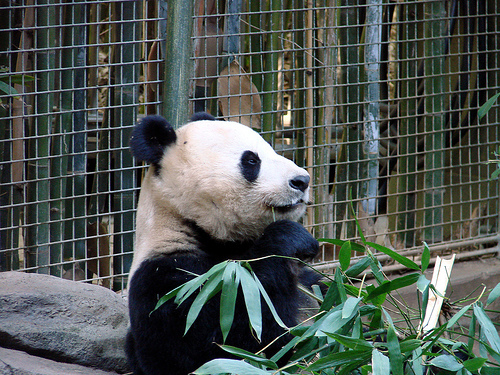

In [7]:
# show the sample of the panda
image_sample('pandas')

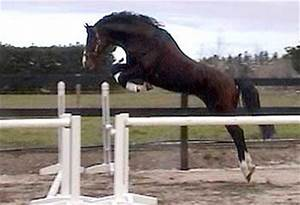

In [8]:
# show the sample of the horse
image_sample('horse')

**Step 2. Preprocess the data to make the dataset suitable for model training**

In [9]:
# Define the transformations, including resize the image, convert the  dataset to pytorch tensor and normalize the dataset
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize(mean=[0.4748, 0.4332, 0.3912], std=[0.2366, 0.2289, 0.2293])
])

In [10]:
# Load the image to creat the dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
# Load the transformed image dataset
dataset = ImageFolder(data_dir,transform = data_transform)

In [11]:
dataset

Dataset ImageFolder
    Number of datapoints: 360
    Root location: animals
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

**Step 3. Split this data between 80% training and 20% test**

In [12]:
import torch
# Split the data into training and testing at the ratio of 80:20
# set the seed value to enhance the reproducibility
torch.manual_seed(3)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [13]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Train dataset size: {len(test_dataset)}')
class_names = dataset.classes
print(f'Dataset categories: {class_names}')

Train dataset size: 288
Train dataset size: 72
Dataset categories: ['dogs', 'horse', 'pandas']


In [14]:
# Visualize the images

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

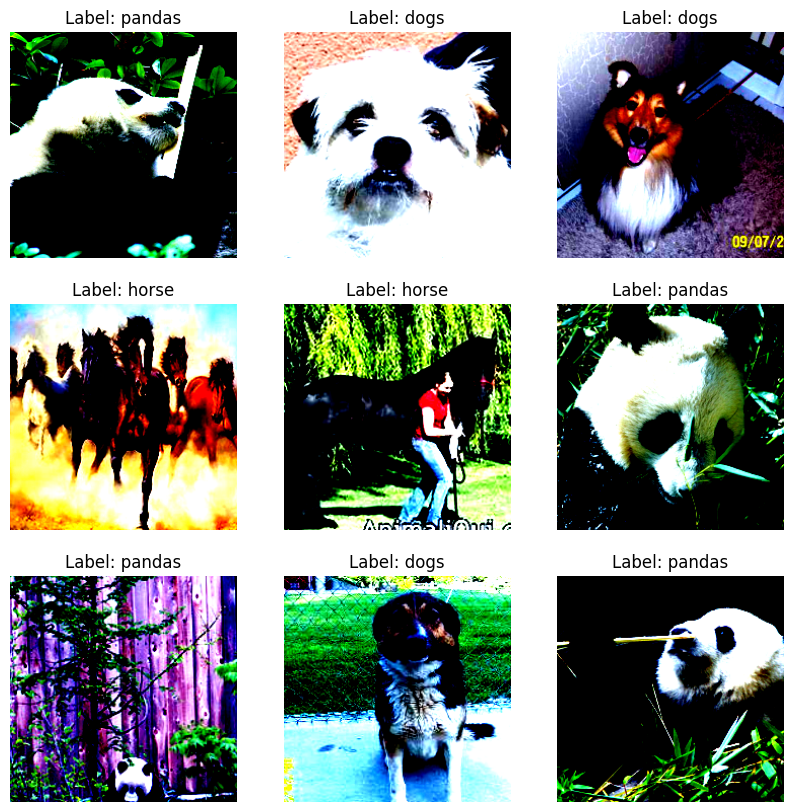

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Create an iterator over the train dataloader object
data_iter = iter(train_dataloader)
# Get the first batch of data from the dataloader
images, labels = next(data_iter)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    # Convert the tensor representing the image to a numpy array.
    # Rearrange the dimensions of the tensor to match the required format for showing the image
    # 0 represents the channels dimension of the original tensor, move to the first
    # 1 represents the height and 2 represents the width
    image = images[i].permute(1, 2, 0).numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

**Step 4. Create a Convolutional Neural Network model to learn about training set**

In [17]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes,img_height,img_width):
        super(CustomCNN, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 28, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(28, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        # Apply max pooling after each convolutional layer, resulting in the size being reduced by 2 * 2 * 2
        self.fc1 = nn.Linear(128 * (img_height // 8) * (img_width // 8), 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = nn.functional.relu(self.conv4(x))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
CNNmodel = CustomCNN(num_classes=3, img_height=224, img_width=224)

Train the CNN Model

In [18]:
import torch.optim as optim
import torch.nn.functional as F

# Define the function to calculate the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training process
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            # images.size() returns (batch, channels, height, width) here
            train_acc += acc.item() * images.size(0)
            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs} Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

In [19]:
# Train the model on the training dataset
optimizer = optim.Adam(CNNmodel.parameters())
criterion = nn.CrossEntropyLoss()
num_epochs = 10
print(f'Model Performance without Data Augmentation:')
train_model(CNNmodel, train_dataloader, criterion, optimizer, num_epochs)

Model Performance without Data Augmentation:
Epoch 1/10 Training Loss: 1.1965, Training Accuracy: 0.4306
Epoch 2/10 Training Loss: 0.9318, Training Accuracy: 0.5521
Epoch 3/10 Training Loss: 0.7184, Training Accuracy: 0.6562
Epoch 4/10 Training Loss: 0.5739, Training Accuracy: 0.7257
Epoch 5/10 Training Loss: 0.4770, Training Accuracy: 0.7639
Epoch 6/10 Training Loss: 0.3809, Training Accuracy: 0.8507
Epoch 7/10 Training Loss: 0.2714, Training Accuracy: 0.8854
Epoch 8/10 Training Loss: 0.1511, Training Accuracy: 0.9375
Epoch 9/10 Training Loss: 0.1236, Training Accuracy: 0.9479
Epoch 10/10 Training Loss: 0.2317, Training Accuracy: 0.8993


Add Data Augmentation Layers to Avoid Overfitting

In [20]:
# Define the training function with data augmentation added before feeding the input into the model
def train_model_with_augmentation(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomVerticalFlip()(img) for img in images])
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=45)(img) for img in data_augmented_inputs])
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training performance
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
# Plot the training dataset after the data augmentation
    plt.figure(figsize=(10, 10))
    for i in range(9):
        image = data_augmented_inputs[i].permute(1, 2, 0).numpy()
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis("off")

Model Performance with Data Augmentation:
Epoch 1/10, Loss: 1.1975, Accuracy: 0.4097
Epoch 2/10, Loss: 1.0252, Accuracy: 0.5278
Epoch 3/10, Loss: 0.8333, Accuracy: 0.6354
Epoch 4/10, Loss: 0.7335, Accuracy: 0.6944
Epoch 5/10, Loss: 0.6213, Accuracy: 0.7326
Epoch 6/10, Loss: 0.4731, Accuracy: 0.8021
Epoch 7/10, Loss: 0.3880, Accuracy: 0.8403
Epoch 8/10, Loss: 0.2676, Accuracy: 0.9028
Epoch 9/10, Loss: 0.2826, Accuracy: 0.8958


Epoch 10/10, Loss: 0.2663, Accuracy: 0.8924


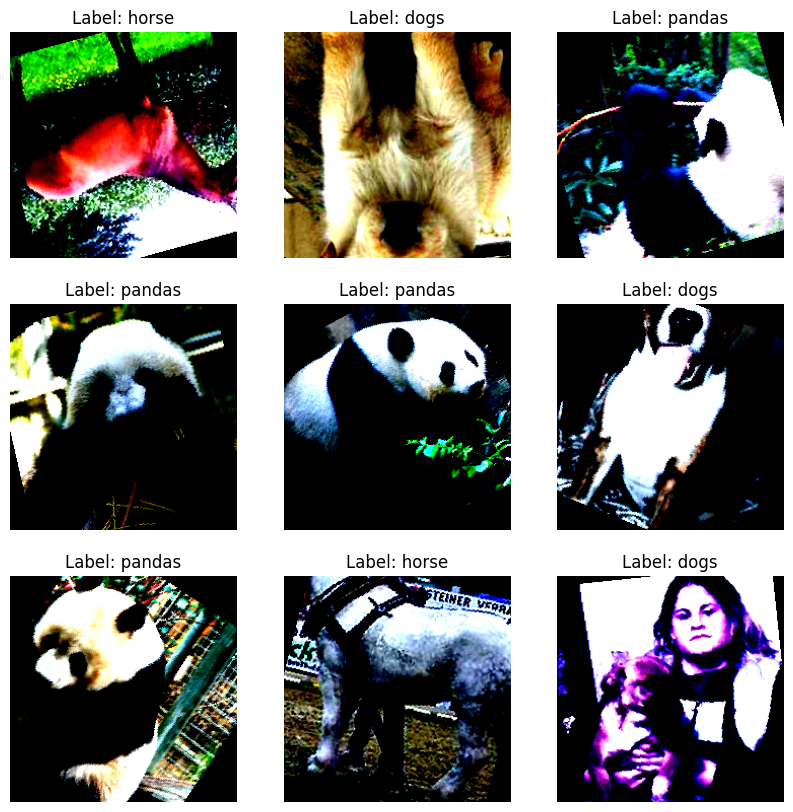

In [21]:
# Train the model
CNNmodel2 = CustomCNN(num_classes=3, img_height=224, img_width=224)
optimizer = optim.Adam(CNNmodel2.parameters())
criterion = nn.CrossEntropyLoss()
num_epochs = 10
print(f'Model Performance with Data Augmentation:')
train_model_with_augmentation(CNNmodel2, train_dataloader, criterion, optimizer, num_epochs)

**Step 5. Make predictions on the test data and compare them to the expected categories**

In [22]:
# Make predictions on the test dataset
def test_accurracy(model, test_dataloader):
    test_acc = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradient calculation
        for images, labels in test_dataloader:
            outputs = model(images)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predictions
            acc = torch.sum(preds == labels).item()  # Compute accuracy
            test_acc += acc
    print(f'The test accuracy is {test_acc / len(test_dataloader.dataset)*100:.4f}')

In [23]:
# Test Accuracy of model without data augmentation
CNNmodel.eval()
test_accurracy(CNNmodel,test_dataloader)

The test accuracy is 59.7222


In [24]:
# Test Accuracy of model with data augmentation
CNNmodel2.eval()
test_accurracy(CNNmodel2,test_dataloader)

The test accuracy is 65.2778


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
def evaluation_visual (model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradient calculation
        for images, labels in test_dataloader:
            outputs = model(images)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predictions
    plt.figure(figsize=(10, 10))
    # Display the image with the predicted class name
    for i in range(8):
        image = images[i].permute(1, 2, 0).numpy()
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis("off")
        plt.text(12, 12, f'Predicted: {class_names[preds[i]]}', fontsize=12, color='white', backgroundcolor='blue')

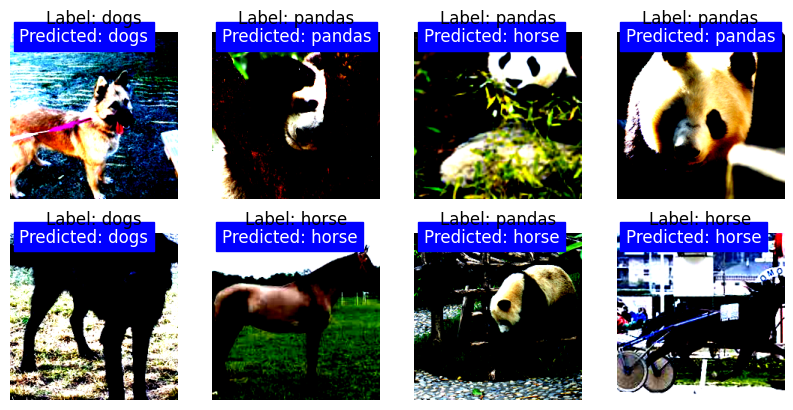

In [26]:
# compare the prediction to the true label
evaluation_visual(CNNmodel2,test_dataloader)

Make the prediction on unseen data

In [27]:
import requests
from io import BytesIO
from torch import argmax
# open the image from the website
#image_url = "https://miro.medium.com/v2/resize:fit:1400/0*AHmHdz45j7Mrwpas"
image_url = 'https://static.scientificamerican.com/sciam/cache/file/83E08CB2-1686-4F82-BA7D9E2B255EC0FD_source.jpg?w=1200'
#image_url = 'https://t4.ftcdn.net/jpg/05/54/52/13/360_F_554521329_ngmDQSjSrUSRnbK2xK0bkcprsinG9Xdv.jpg'
response = requests.get(image_url)
test_image = Image.open(BytesIO(response.content)).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img_tensor = preprocess(test_image)
img_tensor = img_tensor.unsqueeze(0)
# Move the tensor to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)

In [28]:
# Define a function gets the predicted label and confidence
def image_prediction (img_tensor,model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)

    # Convert tensor to numpy array
    predicted_class = class_names[argmax(probabilities)]

    # Print the predicted class and confidence
    predicted_class = class_names[torch.argmax(probabilities)]
    confidence = torch.max(probabilities).item()
    return predicted_class, confidence

This image most likely belongs to dogs with a 65.28% confidence.


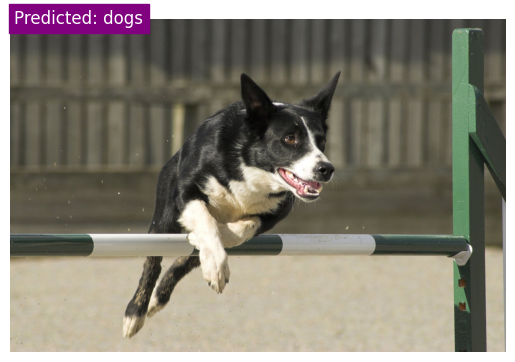

In [29]:
# prediction on unseen image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNNmodel2 = CNNmodel2.to(device)
predicted_class, confidence = image_prediction(img_tensor,CNNmodel2)
print(f"This image most likely belongs to {predicted_class} with a {confidence*100:.2f}% confidence.")
# show the predicition
# Display the image with the predicted class name
image = np.array(test_image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class}', fontsize=12, color='white', backgroundcolor='purple')
plt.show()

In [30]:
# Load and preprocess the unseen image

def visual_predict_image(image_path, model):
    test_image = Image.open(image_path)
    input_tensor = preprocess(test_image)
    # Add a batch dimension
    input_tensor = input_tensor.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)
    # prediction on unseen image
    predicted_class, confidence = image_prediction(input_tensor, model)
    # show the predicition
    # Display the image with the predicted class name
    image = np.array(test_image)
    plt.imshow(test_image)
    plt.axis('off')
    plt.text(10, 10, f'Predicted: {predicted_class}', fontsize=12, color='white', backgroundcolor='purple')
    plt.show()
    print(f"This image most likely belongs to {predicted_class} with a {confidence*100:.2f}% confidence.")

unseen_image/test_image01.jpeg


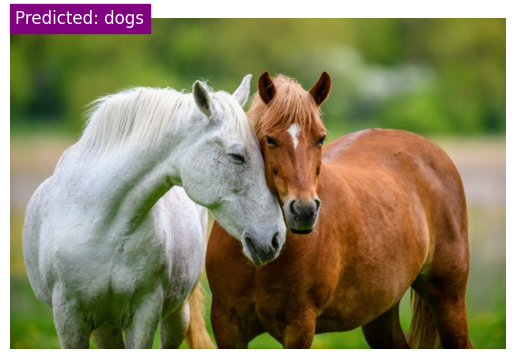

This image most likely belongs to dogs with a 98.67% confidence.
unseen_image/test_image03.jpeg


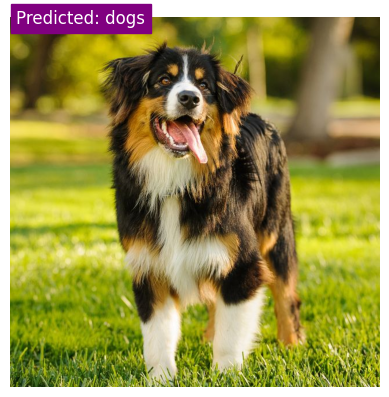

This image most likely belongs to dogs with a 98.51% confidence.
unseen_image/test_image02.jpeg


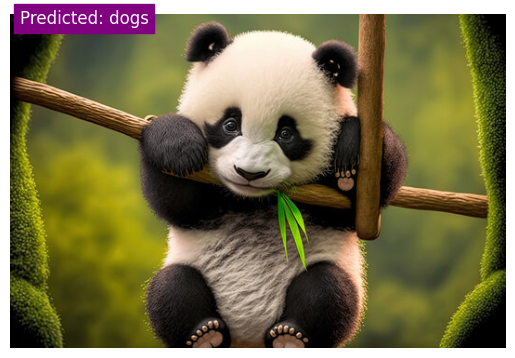

This image most likely belongs to dogs with a 83.28% confidence.


In [42]:
# Test custome model without data augmentation on unseen images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNNmodel = CNNmodel.to(device)
test_dir = 'unseen_image'
for root, _, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            print(image_path)
            visual_predict_image(image_path,CNNmodel)

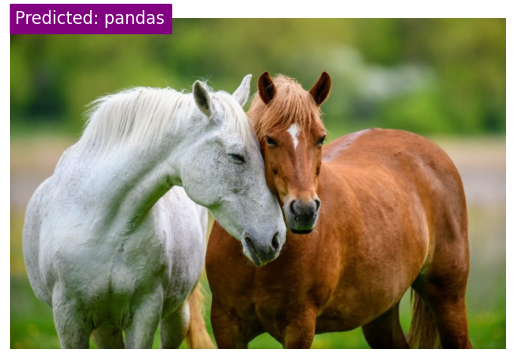

This image most likely belongs to pandas with a 95.14% confidence.


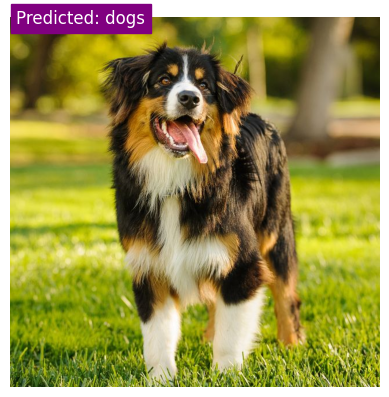

This image most likely belongs to dogs with a 54.67% confidence.


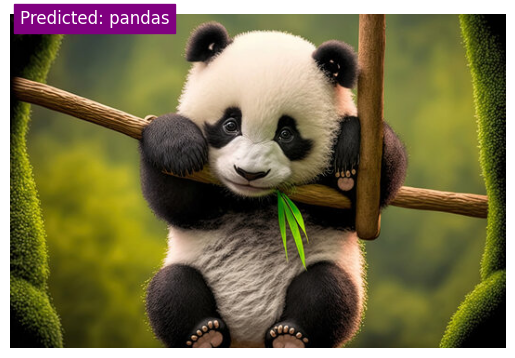

This image most likely belongs to pandas with a 45.79% confidence.


In [43]:
# Test custome model with data augmentation on unseen images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNNmodel2 = CNNmodel2.to(device)
test_dir = 'unseen_image'
for root, _, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            visual_predict_image(image_path,CNNmodel2)

**Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.**

In [33]:
import torchvision.models as models
# Load the pre-trained GoogleNet model
model = models.googlenet(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 101MB/s]


In [34]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

    print(f'{epoch}: Training Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

print("Training complete!")

0: Training Loss: 7.9576, Acc: 0.0000
1: Training Loss: 5.4372, Acc: 0.0625
2: Training Loss: 2.5528, Acc: 0.3368
3: Training Loss: 1.0378, Acc: 0.6597
4: Training Loss: 0.6796, Acc: 0.7847
5: Training Loss: 0.5422, Acc: 0.8229
6: Training Loss: 0.4462, Acc: 0.8472
7: Training Loss: 0.3980, Acc: 0.8854
8: Training Loss: 0.3625, Acc: 0.8889
9: Training Loss: 0.3562, Acc: 0.8854
Training complete!


In [35]:
# Save the model
torch.save(model.state_dict(), 'animal_model_googlenet.pth')

In [36]:
# Load the saved model
pretrain_model = models.googlenet(pretrained=True)
pretrain_model.fc = nn.Linear(pretrain_model.fc.in_features, 1000)  # Adjust to match the original model's output units
pretrain_model.load_state_dict(torch.load('animal_model_googlenet.pth'))

# Create a new model with the correct final layer
new_model = models.googlenet(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 3)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = pretrain_model.fc.weight.data[0:3]  # Copy only the first 3 output units
new_model.fc.bias.data = pretrain_model.fc.bias.data[0:3]

In [37]:
new_model.eval()
# get the test accuracy on the new model based on the googlenet model
test_accurracy(new_model,test_dataloader)

The test accuracy is 98.6111


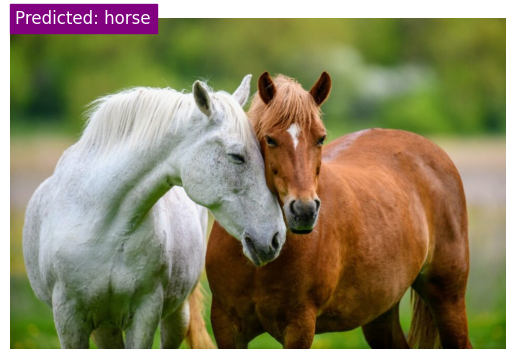

This image most likely belongs to horse with a 94.64% confidence.


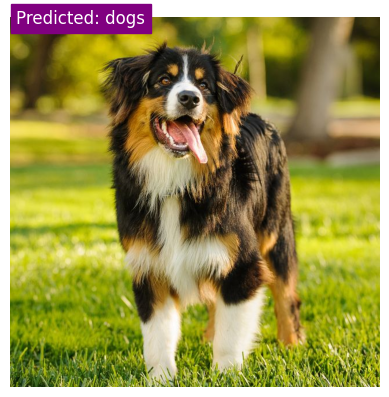

This image most likely belongs to dogs with a 60.70% confidence.


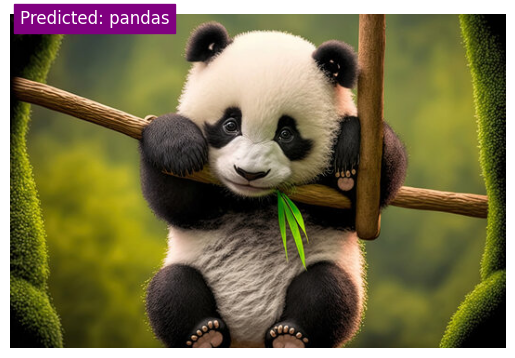

This image most likely belongs to pandas with a 99.24% confidence.


In [44]:
# test on unseen new image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)
test_dir = 'unseen_image'
for root, _, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            visual_predict_image(image_path,new_model)

Conclusion:
The custom CNN without data augmentation achieves a training accuracy of 89.93% while the test accuracy is only 59.72%. For the three new unseen images, it only correctly predicts one out of three.

The custom CNN with data augmentation achieves a training accuracy of 89.24% while the test accuracy is only 65.27%. For the three new unseen images, it correctly predicts three out of three.

The new model built based on GoogLeNet achieves a training accuracy of 88.54% and a testing accuracy of 98.61%. When tested with the three unseen images, it correctly predicts all of them.
As observed, the model based on the GoogLeNet pretrained model outperforms the custom CNN model, significantly improved performance.